To Do:
- Apply sentiment analysis
- news article -> model -> { fakeNews: false, sentiment: 0.23 }

In [113]:
import numpy as np
import pandas as pd
import itertools
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt

#from nltk.classify import NaiveBayesClassifier
#from nltk.corpus import subjectivity
#from nltk.sentiment import SentimentAnalyzer
#from nltk.sentiment.util import *

import nltk
nltk.download('subjectivity')
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer

# experiment using xgboost after encoding label with labelencoder
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import XGBClassifier 


[nltk_data] Downloading package subjectivity to
[nltk_data]     /Users/samuelseokyukim/nltk_data...
[nltk_data]   Package subjectivity is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/samuelseokyukim/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [114]:
# Read the data
df = pd.read_csv('news.csv')

# Get shape and head
df.shape
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [115]:
# Get the labels
X = df['text']
y = df['label']
y.head()

0    FAKE
1    FAKE
2    REAL
3    FAKE
4    REAL
Name: label, dtype: object

In [116]:
# Split the dataset
x_train_uncleaned, x_test_uncleaned, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7)

In [117]:
# Loop through x_train_uncleaned and x_test_uncleaned and clean each article

x_train = []
x_test = []

for document in x_train_uncleaned :
    # Remove all the special characters
    noSpecial = re.sub(r'\W', ' ', document)

    # Remove all single characters
    #noSingle = re.sub(r'\s+[a-zA-Z]\s+', ' ', noSpecial)

    # Remove single characters from the start
    #noSingleFromStart = re.sub(r'\^[a-zA-Z]\s+', ' ', noSingle) 

    # Substituting multiple spaces with single space
    noMultiSpace = re.sub(r'\s+', ' ', noSpecial, flags = re.I)

    # Removing prefixed 'b'
    noPrefixed = re.sub(r'^b\s+', '', noMultiSpace)

    # Convert to Lowercase
    lowercased = noPrefixed.lower()
    
    x_train.append(lowercased)
    
for document in x_test_uncleaned :
    # Remove all the special characters
    noSpecial = re.sub(r'\W', ' ', document)

    # Remove all single characters
    #noSingle = re.sub(r'\s+[a-zA-Z]\s+', ' ', noSpecial)

    # Remove single characters from the start
    #noSingleFromStart = re.sub(r'\^[a-zA-Z]\s+', ' ', noSingle) 

    # Substituting multiple spaces with single space
    noMultiSpace = re.sub(r'\s+', ' ', noSpecial, flags = re.I)

    # Removing prefixed 'b'
    noPrefixed = re.sub(r'^b\s+', '', noMultiSpace)

    # Convert to Lowercase
    lowercased = noPrefixed.lower()
    
    x_test.append(lowercased)




In [118]:
# Accepts a list of strings and pandas dataframe
# Loop through each element in list or dataframe 
# Applies sentiment analysis

def sentiment_analysis(articles_list) :
    
    for article in articles_list :
        
        # Initialize sentiment intensity analyzer
        sentiment_analyzer = SentimentIntensityAnalyzer()
        
        # Print(article)
        results = sentiment_analyzer.polarity_scores(article)
        print('Sentiment analysis results: ')
        
        for k in sorted(results) :
            print('{0}: {1}, '.format(k, results[k]), end = '')
        print()
        
        print("Article was rated as", results['neg'] * 100, "% Negative")
        print("Article was rated as", results['neu'] * 100, "% Neutral")
        print("Article was rated as", results['pos'] * 100, "% Positive")
        print("Overall rating of the article:", end = ' ')
        
        # Determine if an article is overall positive, negative, or neutral
        if results['compound'] >= 0.05 :
            print("Positive")
 
        elif results['compound'] <= - 0.05 :
            print("Negative")
 
        else :
            print("Neutral")


In [119]:
# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features = 50000, 
                                   lowercase = False, 
                                   stop_words = 'english', 
                                   max_df = 0.7, 
                                   ngram_range = (1, 2))

# Fit and transform train set, transform test set
tfidf_train = tfidf_vectorizer.fit_transform(x_train) 
tfidf_test = tfidf_vectorizer.transform(x_test)


In [120]:
# Initialize PassiveAggressiveClassifier
pac = PassiveAggressiveClassifier(max_iter = 500)
pac.fit(tfidf_train, y_train)

# Predict on the test set and calculate accuracy
y_pred = pac.predict(tfidf_test)
score = accuracy_score(y_test, y_pred)
print(f'Accuracy of test: {round(score * 100, 2)}%')

Accuracy of test: 93.84%


In [121]:
# Build confusion matrix: [[true positive, false negative], [false positive, true negative]]
confusion_matrix(y_test, y_pred, labels = ['REAL', 'FAKE'])

array([[595,  34],
       [ 44, 594]])

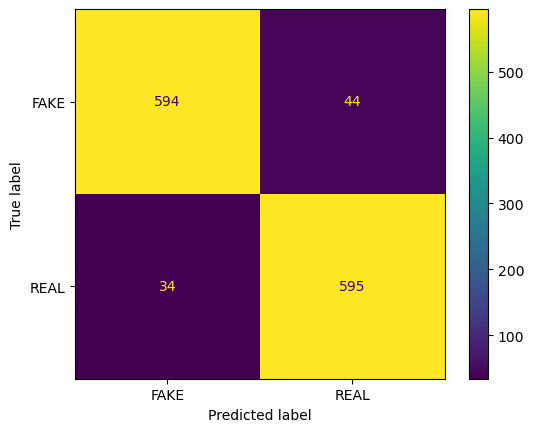

In [122]:
# Display confusion matrix
# Top left: true negative
# Top right: false positive
# Bottom left: false negative
# Bottom right: true positive
cm = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['FAKE', 'REAL'])
cm_display.plot()
plt.show()

In [123]:
# Test a random article from the Wall Street Journal
expected_y = ['REAL']
x_test_1 = ['Fishing is never an easy way to make a living, but it’s even harder when the federal bureaucracy can put you out of business on a whim. Herring fishermen are fighting back, with potentially large implications for the administrative state. In 2020 the National Marine Fisheries Service (NMFS) decreed that Atlantic herring fishermen must include a human monitor to ensure compliance with catch limits. The fishermen must pay for the monitor, though many are small, independent operators. By the fisheries service’s own estimate, its mandate costs each boat $710 a day. Depending on the catch, this is often more than the captains make on a trip. Even the service acknowledges that the monitoring cost will reduce herring operations’ annual returns by 20%. Enter the Cause of Action Institute, which sued the Commerce Department (which oversees the NMFS) in 2020 on behalf of fishermen in New Jersey. The suit claims Congress never authorized the bureaucratic cost-shift to the industry. The 1976 Magnuson-Stevens Act governs fishing in federal waters and allows the fisheries service to impose monitors. But nowhere in the law does Congress give the service power to force herring fishermen to fund the program. Congress has authorized industry-funded monitoring in other, specific contexts—including for certain North Pacific fisheries, and for foreign vessels. It did not do the same here. The fisheries service argues it has the legal right to impose the costs because the law is silent on the matter. The government points to language authorizing it to take steps that are “necessary and appropriate” to manage fisheries. Put another way, unless Congress explicitly prohibits an action, an agency can proceed. The case has moved up the appellate chain, and in August a divided panel of the D.C. Circuit Court of Appeals ruled for the government. Judges Sri Srinivasan and Judith Rogers cited the Supreme Court’s Chevron deference standard, finding that the law “through its silence, leaves room for agency discretion.” But Judge Justin Walker noted in dissent that this is a principle with no limit. He mused whether the fisheries service could find it “necessary” for fishermen to drive their federal monitors back and forth to the office to save on government gas bills, or whether it could demand fishermen finance other bureaucratic costs. The decision removes one of the few practical constraints on regulatory excess: a lack of resources. If government can write rules and require their targets to pay the costs without explicit Congressional approval, there will be no limit on bureaucratic discretion. The herring fishermen are asking the Supreme Court to hear the case and are represented by former Solicitor General Paul Clement. In West Virginia v. EPA this year, the Court used its major questions doctrine to rein in egregious regulatory overreach. But it has left Chevron as a largely unchecked license for regulators who can still do great harm without Congressional assent. Silence shouldn’t be a bureaucratic license to wreck livelihoods.']
tfidf_vectorizer.fit_transform(x_train)
tfidf_test_1 = tfidf_vectorizer.transform(x_test_1)
actual_y = pac.predict(tfidf_test_1)
score_1 = accuracy_score(expected_y, actual_y)

if expected_y == actual_y :
    print("Results:", actual_y[0])

elif expected_y == ['FAKE'] and actual_y == ['REAL'] :
    print("Results are false positive: news is considered real when it isn't")

elif expected_y == ['REAL'] and actual_y == ['FAKE'] :
    print("Results are false negative: news is considered fake when it isn't")

print(f'Accuracy of the results: {round(score_1 * 100, 2)}%')

# Apply sentiment analysis
sentiment_analysis(x_test_1)


Results: REAL
Accuracy of the results: 100.0%
Sentiment analysis results: 
compound: -0.6524, neg: 0.075, neu: 0.866, pos: 0.059, 
Article was rated as 7.5 % Negative
Article was rated as 86.6 % Neutral
Article was rated as 5.8999999999999995 % Positive
Overall rating of the article: Negative


In [124]:
# We have a true positive. Confusion matrix of the article from WSJ
confusion_matrix(expected_y_2, actual_y_2, labels = ['REAL', 'FAKE'])

array([[0, 1],
       [0, 0]])

In [125]:
# Test a random article from CNN
expected_y_2 = ['REAL']
x_test_2 = ['Another batch of classified government records were found by President Joe Biden’s legal team, following the initial discovery of classified documents at his former think tank office in Washington this past fall. According to people briefed on the matter, the additional classified documents were found in a second location during searches that took place after lawyers found the initial classified documents. That effort led to the discovery of additional documents of interest to federal officials reviewing the matter, one of the sources said. NBC News first reported the new batch of classified documents. The discovery of the classified documents in his former office in November set off alarm bells inside the White House, where only a small circle of advisers and lawyers were aware of the matter. An effort was launched to search other locations where documents from Biden’s time as vice president may have been stored. The White House declined to comment on the matter. CNN previously reported that the initial batch discovered when Biden’s personal attorneys were packing files at his former private office contained 10 classified documents, including US intelligence materials and briefing memos about Ukraine, Iran and the United Kingdom. Some of the classified documents were “top secret,” the highest level. They were found in three or four boxes that also contained unclassified papers that fall under the Presidential Records Act, CNN has reported. Classified records are supposed to be stored in secure locations. And under the Presidential Records Act, White House records are supposed to go to the National Archives when an administration ends. It is unclear at this time how many documents were in the second batch of documents or what the documents were about. It is also unclear exactly where the new batch of materials were located. Prior to new reports about the second batch of government materials on Wednesday, the White House refused to answer a number of critical questions about the classified documents from Biden’s time as vice president discovered inside a private office last fall, citing an ongoing Department of Justice review. The documents were discovered on November 2, just six days before the midterm elections, but the president’s attorneys only publicly acknowledged the discovery of the documents on Monday – when news reports about the discovery broke. The government materials were found while closing out a Washington, DC-based office – the Penn Biden Center for Diplomacy and Global Engagement. The items discovered include 10 classified documents including US intelligence memos and briefing materials that covered topics including Ukraine, Iran and the United Kingdom, according to a source familiar with the matter. Biden said Tuesday that he did not know that some classified documents had been taken to his private office after he had left the vice presidency and that his attorneys “did what they should have done” by immediately contacting the National Archives and Records Administration after the documents were found in November. The documents, the president said, were found in “a box, locked cabinet – or at least a closet.” Still, key questions about the situation remain unanswered. White House press secretary Karine Jean-Pierre refused to answer a number questions about the documents, citing the Justice Department’s ongoing review of the matter. She could not say who brought the documents into the office or whether other documents were found. Nor could she say whether an audit was underway to locate other possible documents or when the president had been briefed on the discovery of the documents. She also could not provide assurances there weren’t any additional classified materials in any other offices. “This is under review by the Department of Justice. I’m not going to go beyond what the president shared yesterday,” Jean-Pierre said, repeating the explanation in so many words over the course of Wednesday’s press briefing. “I’m not going to go beyond what my colleagues at the White House counsel shared with all of you as well.” The situation has triggered criticism by Republicans, who argue that the federal government has set a political double standard in their approach to mishandled documents. But there is a stark contrast between the emerging scenario with Biden and the ongoing saga with former President Donald Trump – who, for instance, resisted turning over the documents in his possession. Trump’s legal team now believes they will benefit from the revelation that Biden had classified documents in his possession after he left office, multiple sources say. On Wednesday, Jean-Pierre could not answer critical questions about why Biden or his lawyers did not disclose the discovery to the public earlier, especially given the timing ahead of the 2022 elections. Jean-Pierre did say she’d spoken with Biden about the unfolding story as they were traveling in Mexico earlier this week. But she said she hadn’t spoken to the president about the documents themselves. Pressed on whether the way the situation has played out has undercut the president’s longstanding public commitment to transparency, Jean-Pierre responded, “When his lawyers realized that these documents were there, they turned them over to the Archives. They did the right thing.” Attorney General Merrick Garland has asked the US attorney in Chicago to review the matter, a source familiar with the matter previously told CNN, a process that is still in a preliminary stage. That US attorney, John Lausch Jr., has already completed the initial part of his inquiry, a source familiar with his work told CNN. He has provided his preliminary findings to Garland, the source said. That means Garland now faces a critical decision on how to proceed, including whether to open a full-blown criminal investigation. Garland was also personally involved in some of the key decision-making related to the Trump documents investigation and the decision to send the FBI to search Mar-a-Lago. Trump’s legal team has argued privately that the revelation of the documents in Biden’s possession puts Garland in a tough position of deciding whether to appoint a special counsel. While Republicans and Trump’s allies have drawn comparisons between the two, Trump had several hundred documents at his Mar-a-Lago residence and resisted the government’s efforts to retrieve them while Biden’s attorneys turned the documents over the day after finding them. Yet Trump’s legal team has discussed the matter internally and ultimately believes it will help their legal case, including their argument about how easy it is for former presidents to take documents labeled classified when they leave office. “This is huge for us,” one source close to the legal team told CNN. South Carolina Republican Sen. Lindsey Graham, who sits on the Senate Judiciary Committee, is calling on Garland to appoint a special counsel to investigate the matter. “I think if you believe a special counsel is necessary to assure the public about the handling of classified documents by Donald Trump, you should apply a special counsel to the mishandling of classified documents by President Biden when he was Vice President,” Graham said on Fox News earlier Wednesday. The White House is also facing bipartisan scrutiny from the Senate Intelligence Committee, the leaders of which sent a letter to Director of National Intelligence Avril Haines asking for access to the documents found at Biden’s private office, a spokesperson for Sen. Marco Rubio told CNN. The letter from Rubio and the committee’s chairman, Democratic Sen. Mark Warner of Virginia, also requests the DNI provide a damage assessment as well as a briefing on both the documents found at Biden’s office and those recovered from Trump’s Mar-a-Lago residence, the spokesperson added. Warner and Rubio submitted a nearly identical request for information following the Mar-a-Lago raid.']
tfidf_vectorizer.fit_transform(x_train)
tfidf_test_2 = tfidf_vectorizer.transform(x_test_2)
actual_y_2 = clf.predict(tfidf_test_2)
score_2 = accuracy_score(expected_y_2, actual_y_2)

if expected_y_2 == actual_y_2 :
    print("Results:", actual_y_2[0])

elif expected_y_2 == ['FAKE'] and actual_y_2 == ['REAL'] :
    print("Results are false positive: news is considered real when it isn't")

elif expected_y_2 == ['REAL'] and actual_y_2 == ['FAKE'] :
    print("Results are false negative: news is considered fake when it isn't")

print(f'Accuracy of the results: {round(score_2 * 100, 2)}%')

# Apply sentiment analysis
sentiment_analysis(x_test_2)


Results are false negative: news is considered fake when it isn't
Accuracy of the results: 0.0%
Sentiment analysis results: 
compound: 0.9942, neg: 0.036, neu: 0.88, pos: 0.084, 
Article was rated as 3.5999999999999996 % Negative
Article was rated as 88.0 % Neutral
Article was rated as 8.4 % Positive
Overall rating of the article: Positive


In [126]:
# We have a false negative... or is it? Confusion matrix of the article from CNN
confusion_matrix(expected_y_2, actual_y_2, labels = ['REAL', 'FAKE'])

array([[0, 1],
       [0, 0]])

In [127]:
# Test a random fake news article from the onion
expected_y_3 = ['FAKE']
x_test_3 = ['NEW YORK—Emphasizing that the researchers were by no means happy about these results, an unfortunate study published by Columbia University this week found that abusing restaurant waitstaff is the secret to living a longer, happier life. “After tracking thousands of individuals over a period of two decades, we can say with regrettable certainty that treating food service workers like subhuman garbage is the single most important factor in enhancing the length and quality of a human lifespan,” said the study’s lead author Dr. Elizabeth Mitran, who reluctantly explained that just 30 seconds of screaming at a waiter for slow entrées carries greater benefits than an hour of vigorous exercise.“We can’t in good conscience endorse this behavior, but every waiter you make cry adds another year to your life.”']
tfidf_test_3 = tfidf_vectorizer.transform(x_test_3)
actual_y_3 = pac.predict(tfidf_test_3)
score_3 = accuracy_score(expected_y_3, actual_y_3)

if expected_y_3 == actual_y_3 :
    print("Results:", actual_y_3[0])

elif expected_y_3 == ['FAKE'] and actual_y_3 == ['REAL'] :
    print("Results are false positive: news is considered real when it isn't")

elif expected_y_3 == ['REAL'] and actual_y_3 == ['FAKE'] :
    print("Results are false negative: news is considered fake when it isn't")

print(f'Accuracy of the results: {round(score_3 * 100, 2)}%')

# Apply sentiment analysis
sentiment_analysis(x_test_3)


Results: FAKE
Accuracy of the results: 100.0%
Sentiment analysis results: 
compound: -0.1036, neg: 0.107, neu: 0.775, pos: 0.118, 
Article was rated as 10.7 % Negative
Article was rated as 77.5 % Neutral
Article was rated as 11.799999999999999 % Positive
Overall rating of the article: Negative


In [128]:
# Confusion matrix of the fake news article
confusion_matrix(expected_y_3, actual_y_3, labels = ['REAL', 'FAKE'])

array([[0, 0],
       [0, 1]])

In [129]:
type(x_test)

list